In [51]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()


# Create Chat Model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


/var/folders/k9/8k7t8wj134b178f9sp5yz6sw0000gn/T/ipykernel_28795/4164516005.py:5: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


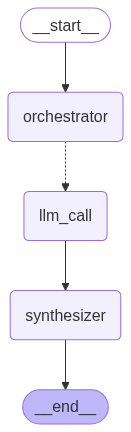

📋 Generated sections: [Section(name='Introduction to Agentic AI Systems', description='An overview of what agentic AI systems are, their capabilities, and their importance in modern technology.'), Section(name='Historical Context', description='A discussion of the evolution of AI systems leading to the development of agentic AI, including key milestones and breakthroughs.'), Section(name='Key Characteristics of Agentic AI Systems', description='An exploration of the features that define agentic AI systems, such as autonomy, adaptability, and decision-making abilities.'), Section(name='Applications of Agentic AI Systems', description='An analysis of various fields where agentic AI systems are being utilized, including healthcare, finance, and robotics.'), Section(name='Ethical Considerations', description='An examination of the ethical implications involved in deploying agentic AI systems, including concerns about bias, accountability, and transparency.'), Section(name='Challenges and L

In [50]:
from typing_extensions import Literal, TypedDict, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from langgraph.constants import Send

from IPython.display import Image, display
import operator

# ====== Define classes ======
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="Brief overview of the main topics and concept of the Section.")

class Sections(BaseModel):
    sections: list[Section] = Field(description="Sections of the report")

# Yeh assume karte hain ke tumhare paas ek LLM object 'llm' defined hai
# Example: from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o-mini")

planner = llm.with_structured_output(Sections)  # LLM se structured output le raha hai

# ====== State definitions ======
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str

class workerState(TypedDict):
    section: Section
    completed_section: Annotated[list, operator.add]

# ====== Orchestrator ======
def orchestrator(state: State):
    """Generates a plan for the report"""
    report_sections = planner.invoke([
        HumanMessage(content="Generate a plan for the report"),
        SystemMessage(content=f"Here is the report topic: {state['topic']}"),
    ])
    print("📋 Generated sections:", report_sections.sections)
    return {"sections": report_sections.sections}

# ====== Worker ======
def call_llm(state: workerState):
    """Writes a section for the report"""
    section_output = llm.invoke([
        SystemMessage(content="Write a report section following the provided name and description. Include no preamble."),
        HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
    ])
    return {"completed_section": [section_output.content]}

def assign_workers(state: State):
    """Assigns workers to each section"""
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Combines all sections into a final report"""
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

# ====== Build Graph ======
orchestrator_worker_builder = StateGraph(State)

# Add nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", call_llm)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile
orchestrator_worker = orchestrator_worker_builder.compile()

# Show workflow graph
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# ====== Run workflow ======
final_state = orchestrator_worker.invoke({
    "topic": "Agentic AI Systems",
    "completed_sections": []
})

# Print final report
print("\n📄 Final Report:\n", final_state["final_report"])


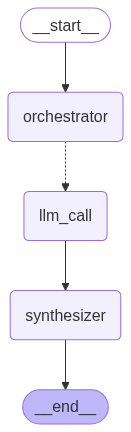

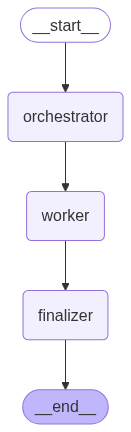

📋 Generated sections: [Section(name='Introduction to Agentic AI Systems', description='Overview of what agentic AI systems are, their characteristics, and significance in the current technological landscape.'), Section(name='Historical Context', description='Discussion of the evolution of AI leading up to the development of agentic systems, including key milestones and breakthroughs.'), Section(name='Core Components of Agentic AI Systems', description='Examination of the fundamental components that define agentic AI, including autonomy, adaptability, and decision-making capabilities.'), Section(name='Applications of Agentic AI Systems', description='Analysis of various fields where agentic AI is applied including healthcare, finance, autonomous vehicles, and robotics.'), Section(name='Ethical Implications and Challenges', description='Exploration of the ethical considerations, potential risks, and societal impacts of deploying agentic AI systems.'), Section(name='Regulatory Landscape',

KeyError: 'section'

In [36]:
import operator
from typing_extensions import Annotated, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

# ==== MODELS ====
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="Brief overview of the section topics.")

class Sections(BaseModel):
    sections: list[Section] = Field(description="List of sections in the report.")

# ==== LLM + Structured Output Planner ====
llm = ChatOpenAI(model="gpt-4o-mini")  
planner = llm.with_structured_output(Sections)

# ==== STATES ====
class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list[str], operator.add]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list[str], operator.add]

# ==== ORCHESTRATOR ====
def orchestrator(state: State):
    """Generates the plan for the report and sends tasks to workers."""
    report_sections = planner.invoke([
        HumanMessage(content="Generate a plan for the report."),
        SystemMessage(content=f"Here is the report topic: {state['topic']}"),
    ])
    
    print("📋 Generated sections:", report_sections.sections)

    sends = [
        ("worker", {"section": section})
        for section in report_sections.sections
    ]

    return {
        "sections": report_sections.sections,
        "__send__": sends
    }

# ==== WORKER ====
def worker(state: WorkerState):
    """Writes the content for one section."""
    result = llm.invoke(f"Write the section '{state['section'].name}': {state['section'].description}")
    return {"completed_sections": [result.content]}

# ==== FINALIZER ====
def finalizer(state: State):
    """Combine all completed sections into the final report."""
    report = "\n\n".join(state["completed_sections"])
    return {"final_report": report}

# ==== BUILD GRAPH ====
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("worker", worker)
builder.add_node("finalizer", finalizer)

# This is the "map-reduce" setup
builder.add_edge(START, "orchestrator")           # start → orchestrator
builder.add_edge("orchestrator", "worker")        # orchestrator → each worker
builder.add_edge("worker", "finalizer")           # after ALL workers → finalizer
builder.add_edge("finalizer", END)                # finalizer → end

app = builder.compile()

# ==== VISUALIZE GRAPH ====
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# ==== RUN ====
final_state = app.invoke({
    "topic": "Agentic AI Systems",
    "completed_sections": []  # must be initialized for operator.add
})

print("\n📄 Final Report:\n", final_state["final_report"])
